In [2]:
# PROJECT INFORMATION
# Project the bike rental demand  of Capital Bike Share.
# Task: To create a model (or several models) to forcast the amount of bikes used.
# The core data set is related to the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA
# Associated tasks
# 1. Regression: Predication of bike rental count hourly or daily based on the environmental and seasonal settings.
# 2. Event and Anomaly Detection: Count of rented bikes are also correlated to some events in the town which easily are traceable via search engines.
# For instance, query like "2012-10-30 washington d.c." in Google returns related results to Hurricane Sandy. Some of the important events are 
# identified in [1]. Therefore the data can be used for validation of anomaly or event detection algorithms as well.
# - hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
# - day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

# Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
# - instant: record index
# 	- dteday : date
# 	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
# 	- yr : year (0: 2011, 1:2012)
# 	- mnth : month ( 1 to 12)
# 	- hr : hour (0 to 23)
# 	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
# 	- weekday : day of the week
# 	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
# 	+ weathersit : 
# 		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
# 	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
# 	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
# 	- hum: Normalized humidity. The values are divided to 100 (max)
# 	- windspeed: Normalized wind speed. The values are divided to 67 (max)
# 	- casual: count of casual users
# 	- cbstered: count of cbstered users
# 	- cnt: count of total rental bikes including both casual and registered

EDA

In [3]:
#import stuff
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import requests
import zipfile
import io
import folium 
from datetime import date

In [4]:
# IMPORT DATA: DECLARE FILE PATH AND READ CSVs in FILEPATH
file_path_hour = r'C:\Users\rsend\Documents\2.) Coding\Projects(repository)\Source data\hour.csv'
file_path_day = r'C:\Users\rsend\Documents\2.) Coding\Projects(repository)\Source data\day.csv'

# Use pd.read_csv() to read the CSV file
data_hour = pd.read_csv(file_path_hour)
data_day = pd.read_csv(file_path_day)

In [5]:
# EDA: Get a first impression of the data 

# data_hour.count() # 27379
# data_day.count()  # 732
# # data_day.describe()
# data_hour.describe()
# data_hour.shape
# print(data_hour.size)
# data_hour.info()
# data_day.shape
# print(data_day.size)
# data_day.info()
# data_hour.isnull().sum()
# # data_day.isna()
# data_hour.info()

# # day_no_dups.count() #731 no duplicates! 
# hour_no_dups = data_hour.drop_duplicates()
# hour_no_dups.count() #17379 no duplicates! 
# day_no_dups = data_day.drop_duplicates()

In [6]:
# Data day is scaled: Hence need to 
#1 rescale data 
#2 perform conversion 
#3 create necessary data features that are missing

# Convert dte_day into new features Month and day
data_day["dteday"] = pd.to_datetime(data_day["dteday"], format = "%Y/%m/%d")
data_day["dteMonthC"] = pd.to_datetime(data_day["dteday"], format = "%Y/%m/%d").dt.month

# Assuming you have your scaled data in 'scaled_temp' / # Define the original range of your temperature data (e.g., 0-1)
# for temp
og_min = 0
og_max = 1

# set feature for variable: temp, atemp, windspeed, humidity
temp = data_day['temp']
atemp = data_day['atemp']
windspeed = data_day['windspeed']
hum = data_day['hum']

# Define the desired Celsius range (e.g., 0-100)
celsius_min = -8
celsius_max = 39

# Scale the data back to the Celsius range (temp)
converted_temp = (temp - og_min) * (celsius_max - celsius_min) / (og_max - og_min) + celsius_min
# Scale the data back to the Celsius range (atemp)
converted_atemp = (atemp - og_min) * (celsius_max - celsius_min) / (og_max - og_min) + celsius_min

# Create a new column 'converted_temp or atemp' in your DataFrame
data_day['converted_temp'] = converted_temp
data_day['converted_atemp'] = converted_atemp

# define the windspeed range
wind_min = 0
wind_max = 67
hum_min = 0
hum_max = 100

# Perform conversion of wind & humidity
converted_wind = (windspeed - og_min) * (wind_max - wind_min) / (og_max - og_min) + wind_min
converted_hum = (hum - og_min) * (hum_max - hum_min) / (og_max - og_min) + hum_min

# Round converted values for readibility
data_day['converted_wind'] = converted_wind.round(2)
data_day['converted_hum'] = converted_hum.round(2)

# -- performed rescaling and data conversion. Now going for feature engineerin 

# Create copy data_day_base
data_day_base = data_day.copy()

# Create Mappings for Days in str & int :  because the included mappings are american and go from 0-Sunday to 6-Monday. We want 0 Monday to 6Sunday.
american_calender = {0: 'Sunday', 1: 'Monday', 2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
european_calender = {'Monday': 0, 'Tuesday':1, 'Wednesday':2,'Thursday':3,'Friday':4, 'Saturday':5,'Sunday':6}

# Create new variable and set equal to column weekday
data_day['Mon_to_Sun'] = data_day['weekday']
# Replace Mon_to_Sun with new mapping
data_day['Mon_to_Sun'] = data_day['Mon_to_Sun'].replace(american_calender)

# Same process for 
data_day['reconverted_weekdays'] = data_day['Mon_to_Sun']
data_day['reconverted_weekdays'] = data_day['Mon_to_Sun'].replace(european_calender)

# Create new feature: is_weekend as string
data_day.loc[data_day['reconverted_weekdays'] == 5, 'is_weekdend'] = 'Yes'
data_day.loc[data_day['reconverted_weekdays'] == 6, 'is_weekdend'] = 'Yes'
data_day.loc[data_day['reconverted_weekdays'] == 0, 'is_weekdend'] = 'No'
data_day.loc[data_day['reconverted_weekdays'] == 1, 'is_weekdend'] = 'No'
data_day.loc[data_day['reconverted_weekdays'] == 2, 'is_weekdend'] = 'No'
data_day.loc[data_day['reconverted_weekdays'] == 3, 'is_weekdend'] = 'No'
data_day.loc[data_day['reconverted_weekdays'] == 4, 'is_weekdend'] = 'No'


# EDA #Drop Column instant because it is not needed
data_day = data_day.drop(columns='instant')

In [7]:
# EDA CREATE NEW EXCEL FILE FOR EXCEL ANALYSIS

# Specify the path and filename for the Excel file you want to create
excel_file_path = r'C:\Users\rsend\Documents\2.) Coding\Projects(repository)\Source data\converted.xlsx'

# Use the to_excel method to export the DataFrame to Excel
# data_day.to_excel(excel_file_path, index=False)  # Set index=False if you don't want to export the DataFrame index

In [8]:
data_hour.tail(15)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17364,17365,2012-12-31,1,1,12,9,0,1,1,2,0.18,0.2121,0.64,0.1045,13,144,157
17365,17366,2012-12-31,1,1,12,10,0,1,1,2,0.20,0.2121,0.69,0.1343,33,87,120
17366,17367,2012-12-31,1,1,12,11,0,1,1,2,0.22,0.2273,0.60,0.1940,43,114,157
17367,17368,2012-12-31,1,1,12,12,0,1,1,2,0.24,0.2273,0.56,0.1940,52,172,224
17368,17369,2012-12-31,1,1,12,13,0,1,1,2,0.26,0.2576,0.44,0.1642,38,165,203
17369,17370,2012-12-31,1,1,12,14,0,1,1,2,0.28,0.2727,0.45,0.2239,62,185,247
17370,17371,2012-12-31,1,1,12,15,0,1,1,2,0.28,0.2879,0.45,0.1343,69,246,315
17371,17372,2012-12-31,1,1,12,16,0,1,1,2,0.26,0.2576,0.48,0.1940,30,184,214
17372,17373,2012-12-31,1,1,12,17,0,1,1,2,0.26,0.2879,0.48,0.0896,14,150,164
17373,17374,2012-12-31,1,1,12,18,0,1,1,2,0.26,0.2727,0.48,0.1343,10,112,122


In [9]:
# Data day is scaled: Hence need to 
#1 rescale data 
#2 perform conversion 
#3 create necessary data features that are missing

# CONVERT dte_day / into new features Month, day and year
data_hour["dteday"] = pd.to_datetime(data_hour["dteday"], format = "%Y/%m/%d")
data_hour["dteMonthC"] = pd.to_datetime(data_hour["dteday"], format = "%Y/%m/%d").dt.month
data_hour["dte_year"] = pd.to_datetime(data_hour["dteday"], format = "%Y/%m/%d").dt.year
data_hour["dte_month"] = pd.to_datetime(data_hour["dteday"], format = "%Y/%m/%d").dt.month

# CONVERT Temp, hum, atemp and windspeeed. Define the original range of your temperature data (e.g., 0-1):
og_min = 0
og_max = 1

# set feature for variable: temp, atemp, windspeed, humidity
temp = data_hour['temp']
atemp = data_hour['atemp']
windspeed = data_hour['windspeed']
hum = data_hour['hum']

# Define the desired Celsius range (e.g., 0-100) for temp
celsius_min = -8
celsius_max = 39
celsius_min_atemp = -16
celsius_max_atemp = 50

# Scale the data back to the Celsius range (temp)
converted_temp = (temp - og_min) * (celsius_max - celsius_min) / (og_max - og_min) + celsius_min
# Scale the data back to the Celsius range (temp)
converted_atemp = (atemp - og_min) * (celsius_max_atemp - celsius_min_atemp) / (og_max - og_min) + celsius_min_atemp

# Create a new column 'converted_temp or atemp' in your DataFrame
data_hour['converted_temp'] = converted_temp
data_hour['converted_atemp'] = converted_atemp

# define the windspeed range
wind_min = 0
wind_max = 67
hum_min = 0
hum_max = 100

# Perform conversion of wind & humidity
converted_wind = (windspeed - og_min) * (wind_max - wind_min) / (og_max - og_min) + wind_min
converted_hum = (hum - og_min) * (hum_max - hum_min) / (og_max - og_min) + hum_min

# Round converted values for readibility
data_hour['converted_wind'] = converted_wind.round(2)
data_hour['converted_hum'] = converted_hum.round(2)

# Create copy data_hour_base
data_hour_base = data_hour.copy()

# Create Mappings for Days in str & int :  because the included mappings are american and go from 0-Sunday to 6-Monday. We want 0 Monday to 6Sunday.
american_calendar = {0: 'Sunday', 1: 'Monday', 2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
european_calendar = {'Monday': 0, 'Tuesday':1, 'Wednesday':2,'Thursday':3,'Friday':4, 'Saturday':5,'Sunday':6}

# HR conversion as hours set were not from 0:00 to 23:00 either:
hr_conversion  = {0:'0:00',1:'1:00',2: '2:00',3: '3:00', 4: '4:00', 5: '5:00',6: '6:00', 7: '7:00',8: '8:00', 9: '9:00', 10: '10:00', 11: '11:00', 12: '12:00', 13: '13:00', 14: '14:00',15: '15:00',16: '16:00',17: '17:00',18: '18:00',19: '19:00',20: '20:00', 21: '21:00', 22: '22:00', 23: '23:00'}

# Declare mapping as variable
data_hour['Mon_to_Sun'] = data_hour['weekday']
data_hour['Mon_to_Sun'] = data_hour['Mon_to_Sun'].replace(american_calendar) 
data_hour['reconverted_weekdays'] = data_hour['Mon_to_Sun']
data_hour['reconverted_weekdays'] = data_hour['Mon_to_Sun'].replace(european_calendar)
data_hour['converted_hr'] = data_hour['hr'].replace(hr_conversion)

# Create feature is_holiday
data_hour.loc[data_hour['holiday'] == 0, 'is_holiday'] = 'No'
data_hour.loc[data_hour['holiday'] == 1, 'is_holiday'] = 'Yes'

# Create new feature: is_weekend as string
data_hour.loc[data_hour['reconverted_weekdays'] == 5, 'is_weekend'] = 'Yes'
data_hour.loc[data_hour['reconverted_weekdays'] == 6, 'is_weekend'] = 'Yes'
data_hour.loc[data_hour['reconverted_weekdays'] == 0, 'is_weekend'] = 'No'
data_hour.loc[data_hour['reconverted_weekdays'] == 1, 'is_weekend'] = 'No'
data_hour.loc[data_hour['reconverted_weekdays'] == 2, 'is_weekend'] = 'No'
data_hour.loc[data_hour['reconverted_weekdays'] == 3, 'is_weekend'] = 'No'
data_hour.loc[data_hour['reconverted_weekdays'] == 4, 'is_weekend'] = 'No'

#Create time_mapping bast on hours
time_mapping = {
    '0:00': '15 past_midnight (0-2am)',
    '1:00': '15 past_midnight (0-2am)',
    '2:00': '16 deep night (2-4am)',
    '3:00': '16 deep night (2-4am)',
    '4:00': '0 deep night/morning (4-5am)',
    '5:00': '0 deep early morning (5-6am)',
    '6:00': '1 early morning (6-7am)',
    '7:00': '2 morning (7-8am)',
    '8:00': '3 morning rush (8-9am)',
    '9:00': '4 late morning rush (9-10am)',
    '10:00': '5 late morning (10-11am)',
    '11:00': '6 early midday (11am-12am)',
    '12:00': '7 midday (12am-2pm)',
    '13:00': '7 midday (12am-2pm)',
    '14:00': '8 early afternoon (2pm-4pm)',
    '15:00': '8 early afternoon (2pm-4pm)',
    '16:00': '9 early evening (4-5pm)',
    '17:00': '9 early evening (5-6pm)',
    '18:00': '10 evening rush hour (7-8pm)',
    '19:00': '10 evening rush hour (7-8pm)',
    '20:00': '11 mid-evening (8-9pm)',
    '21:00': '12 early late evening (9-10pm)',
    '22:00': '13 late evening (10-11pm)',
    '23:00': '14 before midnight (11-12pm)'
}

# set new mapping for new variable clustered_hr_1
data_hour['clustered_hr_1'] = data_hour['converted_hr'].map(time_mapping)

# Create mapping for "phases of the day"
phase_mapping =  {
    '15 past_midnight (0-2am)': 'night/very early morning',
    '16 deep night (2-4am)': 'night/very early morning',
    '0 deep night/morning (4-5am)': 'night/very early morning',
    '0 deep early morning (5-6am)': 'morning',
    '1 early morning (6-7am)': 'morning',
    '2 morning (7-8am)': 'morning',
    '3 morning rush (8-9am)': 'morning',
    '4 late morning rush (9-10am)': 'morning',
    '5 late morning (10-11am)': 'morning',
    '6 early midday (11am-12am)': 'midday',
    '7 midday (12am-2pm)': 'midday',
    '8 early afternoon (2pm-4pm)': 'afternoon',
    '9 early evening (4-5pm)': 'afternoon',
    '9 early evening (5-6pm)': 'evening',
    '10 evening rush hour (7-8pm)': 'evening',
    '11 mid-evening (8-9pm)': 'evening',
    '12 early late evening (9-10pm)': 'evening',
    '13 late evening (10-11pm)': 'evening',
    '14 before midnight (11-12pm)': 'early night'
}

# Set new mapping for new feature clustered_hr_2
data_hour['clustered_hr_2'] = data_hour['clustered_hr_1'].map(phase_mapping)

# Create feature year 0 (2011) and 1 (2012)
data_hour['yr_2011'] = data_hour['yr'] == 0
data_hour['yr_2012'] = data_hour['yr'] == 1

# Create feature ratio registered to casual -- not sure about this
data_hour['ratio_r_users'] = data_hour['registered'] / data_hour['cnt']
data_hour['ratio_c_users'] = data_hour['casual'] / data_hour['cnt']

# Create new feature dte_month
data_hour["dte_month"] = pd.to_datetime(data_hour["dteday"], format="%Y-%m-%d").dt.month

# Create season mapping because the seasons in the initial dataset are messed up
season_mapping = {
    12: 'Winter',
    11: 'Autumn',
    1 : 'Winter',
    2 : 'Winter',
    3 : 'Spring',
    4 : 'Spring',
    5 : 'Spring',
    6 : 'Summer',
    7 : 'Summer',
    8 : 'Summer',
    9 : 'Autumn',
    10 : 'Autumn'
}

#Declare mapping for feature season_2 / declare feature season_2 (--> correct mapping)
data_hour['season_2'] = data_hour['dte_month'].map(season_mapping).astype(str)

# Round all converted values for readability
data_hour['converted_atemp'] = data_hour['converted_atemp'].round(2)
data_hour['atemp']              = data_hour['atemp'].round(2)
data_hour['converted_hum'] = data_hour['converted_hum'].round(2)
data_hour['converted_temp'] = data_hour['converted_temp'].round(2)
data_hour['ratio_c_users'] = data_hour['ratio_c_users'].round(2)
data_hour['ratio_r_users'] = data_hour['ratio_r_users'].round(2)

# Rename  column names
data_hour.rename(columns={'cnt':'Count'},inplace=True)
# data_hour.rename(columns={'cnt':'Count'},inplace=True)

# EDA DROP INSTANT FROM DF DATA_HOUR
data_hour = data_hour.drop(columns='instant')

# data_hour.tail(15)

In [10]:
# EDA: MISSING HRS 

# I notices that 164 hrs are missing from the dataset, now I want to know which ones and why
data_hour['formatted_string'] = data_hour['dteday'].dt.strftime('%Y-%m-%d')

# Create an empty list to store dates with less than 24 entries
calc_days_missing = []

# Iterate through unique dates in 'formatted_string'
for date in data_hour['formatted_string'].unique():
    count = (data_hour['formatted_string'] == date).sum()
    if count < 23:
        calc_days_missing.append(date)

data_hour['data_anomaly'] = data_hour['formatted_string'].isin(calc_days_missing).astype(int)
anomaly_view = data_hour[data_hour['data_anomaly'] == 1]

# data_hour.tail(25)
# data_hour.tail(5)
print(anomaly_view)
print(calc_days_missing)

# Result: Usually night-time/early morning times missing. Very likely that there were simply no customers during those times and hence no datasets created.

          dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
47    2011-01-03       1   0     1   0        0        1           1   
48    2011-01-03       1   0     1   1        0        1           1   
49    2011-01-03       1   0     1   4        0        1           1   
50    2011-01-03       1   0     1   5        0        1           1   
51    2011-01-03       1   0     1   6        0        1           1   
...          ...     ...  ..   ...  ..      ...      ...         ...   
15890 2012-10-30       4   1    10  19        0        2           1   
15891 2012-10-30       4   1    10  20        0        2           1   
15892 2012-10-30       4   1    10  21        0        2           1   
15893 2012-10-30       4   1    10  22        0        2           1   
15894 2012-10-30       4   1    10  23        0        2           1   

       weathersit  temp  ...  is_weekend                  clustered_hr_1  \
47              1  0.22  ...          No        15 past_mid

In [11]:
# Specify the path and filename for the Excel file you want to create
excel_file_path = r'C:\Users\rsend\Desktop\CAB\Week7 Project 3\Source data\converted.xlsx'

In [12]:
data_hour.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,...,dte_year,dte_month,converted_temp,converted_atemp,converted_wind,converted_hum,reconverted_weekdays,ratio_r_users,ratio_c_users,data_anomaly
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475836,...,2011.502561,6.537775,15.358397,15.401116,12.736233,62.722884,3.011451,0.827901,0.172099,0.013407
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.172258,...,0.500008,3.438776,9.050138,11.341858,8.196891,19.292983,2.001966,0.136588,0.136588,0.115013
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,...,2011.000000,1.000000,-7.060000,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.330000,...,2011.000000,4.000000,7.980000,6.000000,7.000000,48.000000,1.000000,0.750000,0.060000,0.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.480000,...,2012.000000,7.000000,15.500000,16.000000,13.000000,63.000000,3.000000,0.850000,0.150000,0.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.620000,...,2012.000000,10.000000,23.020000,25.000000,17.000000,78.000000,5.000000,0.940000,0.250000,0.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,...,2012.000000,12.000000,39.000000,50.000000,57.000000,100.000000,6.000000,1.000000,1.000000,1.000000


EDA Plotting

<Axes: xlabel='mnth', ylabel='registered'>

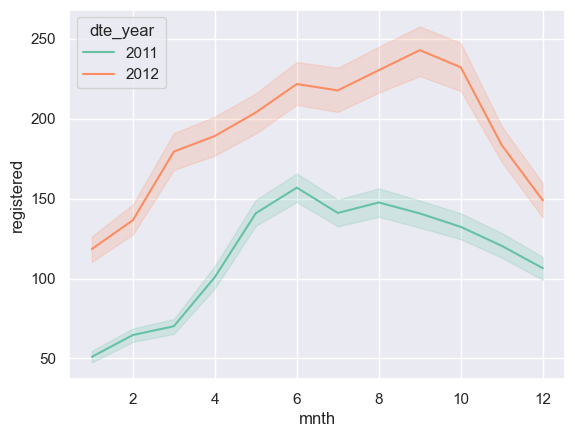

In [13]:
# Let's analyze the development of usage by registered customers over the years split up by months (as seasons should be driving demand in theory)
sns.set_theme(style="darkgrid")
sns.lineplot(x='mnth',y='registered',hue='dte_year', data=data_hour, palette='Set2')

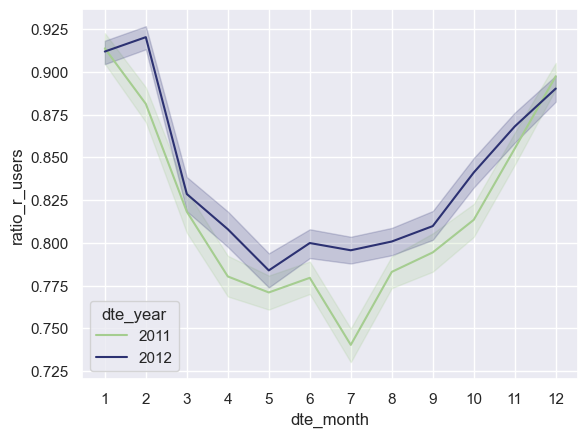

In [14]:
# EDA PLOTTING: ratio users comparing both years and the months

sns.set_theme(style="darkgrid")
sns.lineplot(x='dte_month',y='ratio_r_users',hue='dte_year', data=data_hour, palette='crest')
plt.xticks(data_hour['dte_month'].unique()) 
plt.show()

#As summer approaches the % ratio of registered users goes down and increases again in autumn/winter.

<Figure size 1400x800 with 0 Axes>

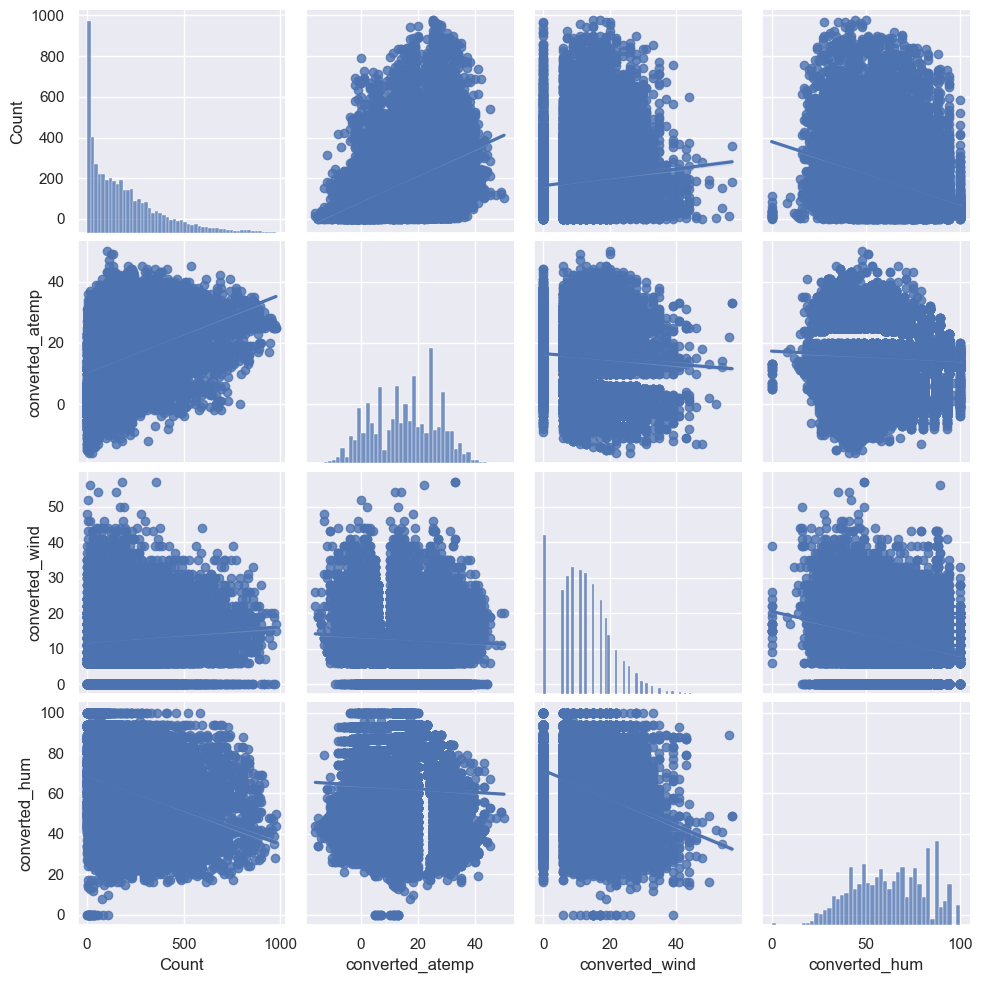

In [15]:
# Okay lets look at the relationship between Count(usage) and some key factors such as perceived temp (converted_atemp), converted_wind, converted_hum(humidity)
plt.figure(figsize=(14,8))
sns.pairplot(data_hour[['Count','converted_atemp','converted_wind','converted_hum']], kind="reg")

C:\Users\rsend\AppData\Local\Temp\ipykernel_20192\2542398296.py:8: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(data=df, x=x, y=y, hue=hue,palette=sns.color_palette("Set2"),sort=False)


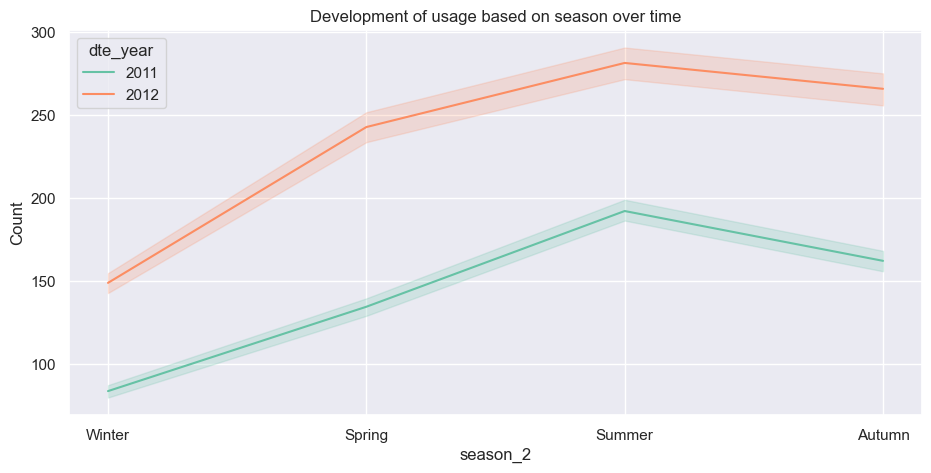

In [16]:
# EDA PLOTTING Development of usage based on season over time (both years, all 4 seasons)

import seaborn as sns
# Draw Plot
def plot_df(df, x, y,hue=None, title="", xlabel='season_2', ylabel='Count', dpi=100):
    plt.figure(figsize=(11,5), dpi=dpi)
    # df['season_2'] = df['season_2'].astype(int)
    sns.lineplot(data=df, x=x, y=y, hue=hue,palette=sns.color_palette("Set2"),sort=False)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel, )
    plt.xticks(df['season_2'].unique())
    plt.show()

plot_df(df=data_hour, x='season_2', y='Count', hue='dte_year',title='Development of usage based on season over time')

[Text(0.5, 1.0, 'Usage over time of the day - per day of the week')]

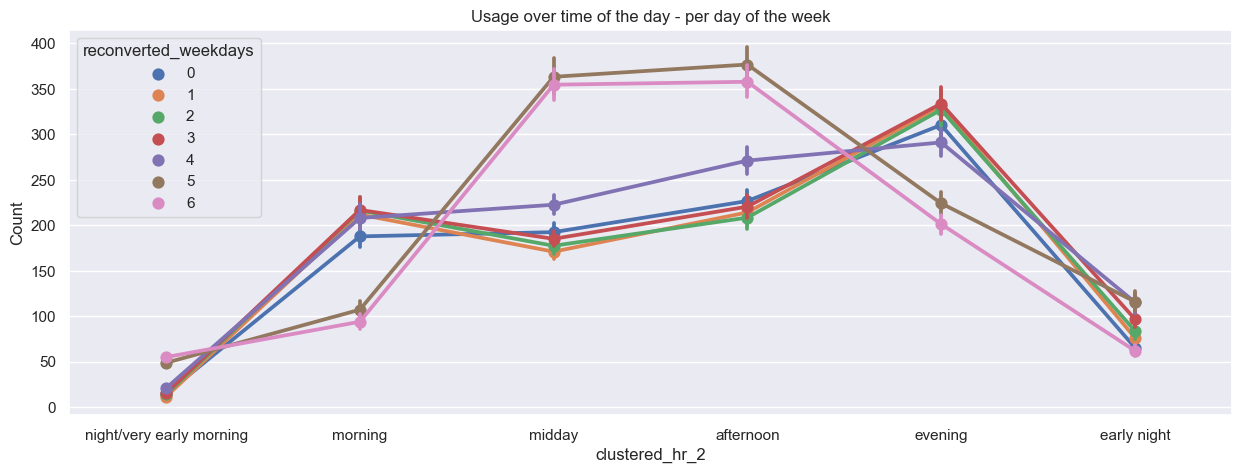

In [17]:
# EDA PLOTTING: Count of bikes during days and hour based on mapping "phase" of the day

fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(data=data_hour, x='clustered_hr_2', y='Count', hue='reconverted_weekdays', ax=ax)
ax.set(title='Usage over time of the day - per day of the week')

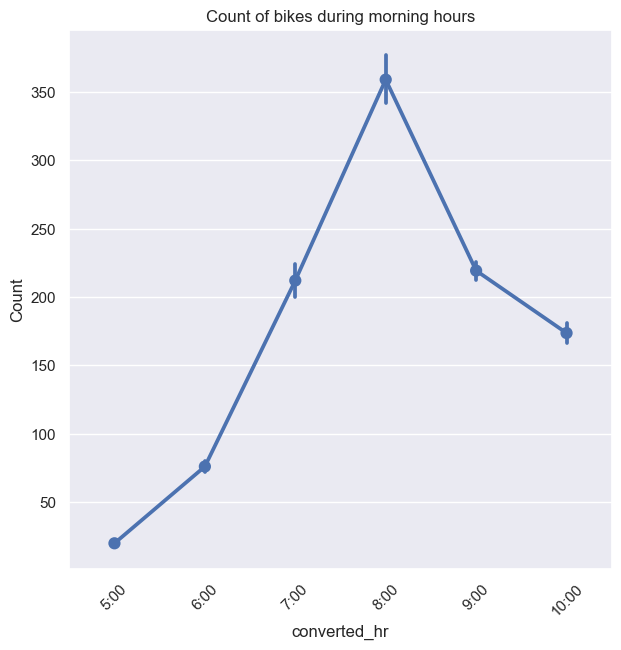

In [18]:
#EDA PLOTTING: Count of bikes during morning hrs

# Filter the DataFrame for the 'morning' phase
morning_data = data_hour[data_hour['clustered_hr_2'] == 'morning']

fig, ax = plt.subplots(figsize=(7, 7))
sns.pointplot(data=morning_data, x='converted_hr', y='Count', hue=None, ax=ax)
ax.set(title='Count of bikes during morning hours')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.show()

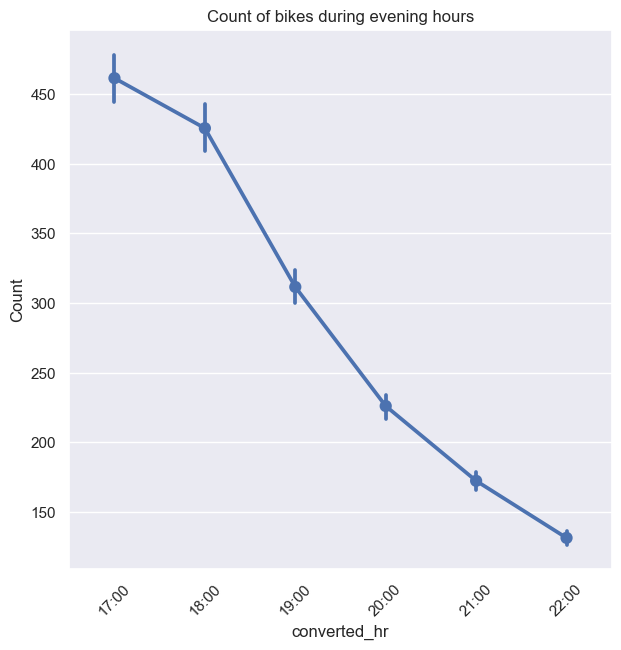

In [19]:
# EDA PLOTTING: COunt of bikes during evening hours

# Filter the DataFrame for the 'morning' phase
evening_data = data_hour[data_hour['clustered_hr_2'] == 'evening']

fig, ax = plt.subplots(figsize=(7, 7))
sns.pointplot(data=evening_data, x='converted_hr', y='Count', hue=None, ax=ax)
ax.set(title='Count of bikes during evening hours')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.show()

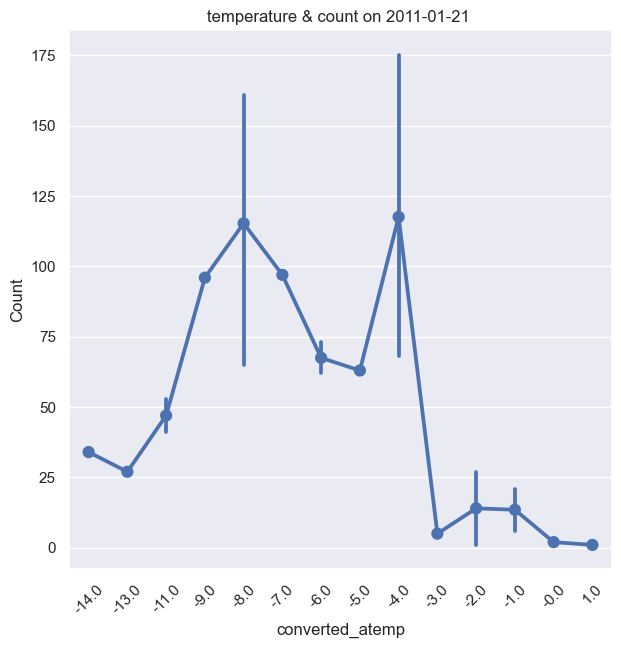

In [20]:
# EDA PLOTTING: temperature & count on 2011-01-21

filtered_data = data_hour[(data_hour['dte_year'] == 2011)&(data_hour['dteday'] == '2011-01-21')]

fig, ax = plt.subplots(figsize=(7, 7))

sns.pointplot(data=filtered_data, x='converted_atemp', y='Count', hue=None, ax=ax)
ax.set(title='temperature & count on 2011-01-21 ')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.show()

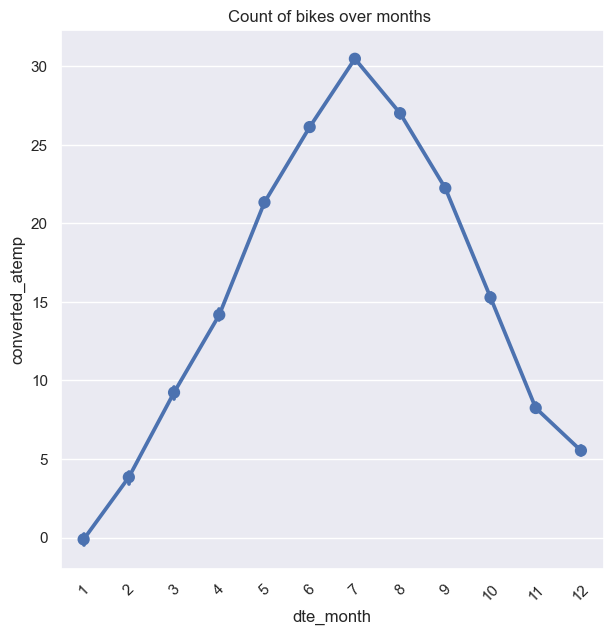

In [21]:
#EDA PLOTTING: Count of bikes over months based on temperature

fig, ax = plt.subplots(figsize=(7, 7))
sns.pointplot(data=data_hour, x='dte_month', y='converted_atemp', hue=None, ax=ax)
ax.set(title='Count of bikes over months ')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.show()

[Text(0.5, 1.0, 'Weekday by minutes')]

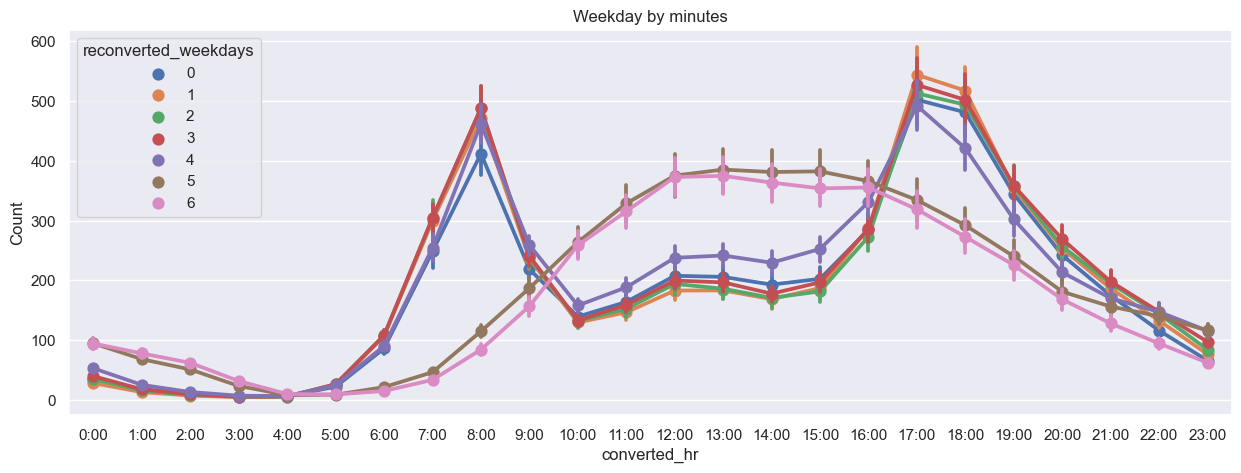

In [22]:
# EDA PLOTTING: USAGE BY HOUR ANd CONVERTED WEEKDAY

fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(data=data_hour, x='converted_hr', y='Count', hue='reconverted_weekdays', ax=ax)
ax.set(title='Weekday by minutes')

[Text(0.5, 1.0, 'Count based on is-weekend? and hour')]

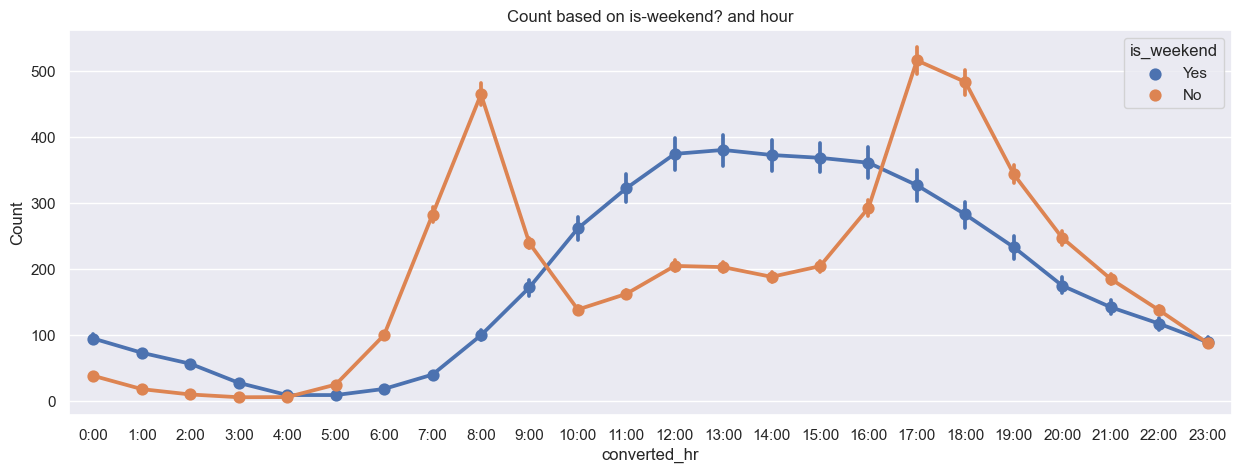

In [23]:
#EDA PLOTTING: USAGE ON WEEKEND DAYS BY HR
fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(data=data_hour, x='converted_hr', y='Count', hue='is_weekend', ax=ax)
ax.set(title='Count based on is-weekend? and hour')

C:\Users\rsend\AppData\Local\Temp\ipykernel_20192\3226767779.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2011['temperature_range'] = pd.cut(data_2011['converted_atemp'], bins=temperature_bins, labels=temperature_labels)


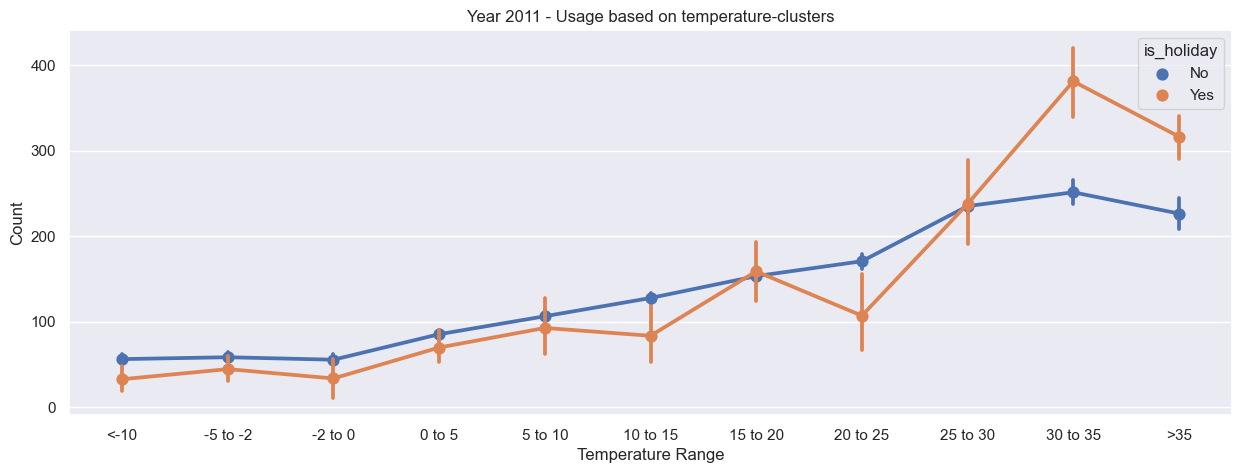

In [24]:
# EDA PLOTTING: Temperature Range , holidays and usage: Need to CREATE TEMPERATURE RANGES

# Filter the data for the year 2011
data_2011 = data_hour[data_hour['dte_year'] == 2011]

# Define the temperature bins
temperature_bins = [-10, -5, -2, 0, 5, 10, 15, 20, 25, 30, 35, 41]

# Create labels for the bins (one fewer label than bin edges)
temperature_labels = ['<-10', '-5 to -2', '-2 to 0', '0 to 5', '5 to 10', '10 to 15', '15 to 20', '20 to 25', '25 to 30', '30 to 35', '>35']

# Create a new column 'temperature_range' based on 'converted_atemp' values
data_2011['temperature_range'] = pd.cut(data_2011['converted_atemp'], bins=temperature_bins, labels=temperature_labels)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(15, 5))

# Create the point plot with the clustered temperature values
sns.pointplot(data=data_2011, x='temperature_range', y='Count', hue='is_holiday', ax=ax)

# Set title and labels
ax.set(title='Year 2011 - Usage based on temperature-clusters', xlabel='Temperature Range', ylabel='Count')

# Show the plot
plt.show()

[Text(0.5, 1.0, 'Count of rides during different months - 2012')]

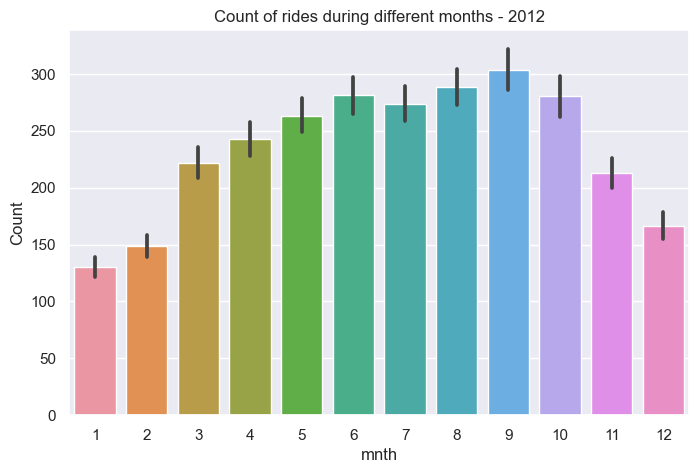

In [25]:
# EDA PLOTTING BarChart: COUNT OF RIDES DURING DIFFERENT MONTHS
data_hour_2011 = data_hour[data_hour['yr'] == 0]
data_hour_2012 = data_hour[data_hour['yr'] ==1]

# data_hour_2012 = data_hour[['yr'] == 1]

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=data_hour_2012, x='mnth', y='Count',ax=ax)
ax.set(title='Count of rides during different months - 2012')

[Text(0.5, 1.0, 'Count of rides during different days of the week 0=Monday to 6=Sunday')]

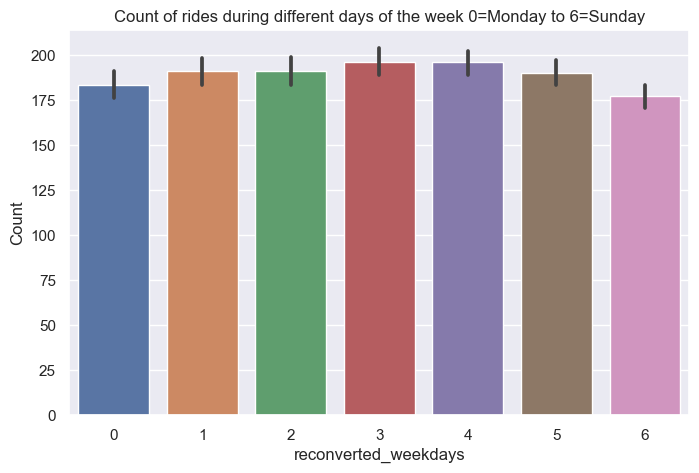

In [26]:
# EDA PLOTTING BarChart: COUNT OF RIDES DURING DIFFERENT Weekdays (0-6)

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=data_hour, x='reconverted_weekdays', y='Count', ax=ax)
ax.set(title='Count of rides during different days of the week 0=Monday to 6=Sunday')

[Text(0.5, 1.0, 'Weekday by hr')]

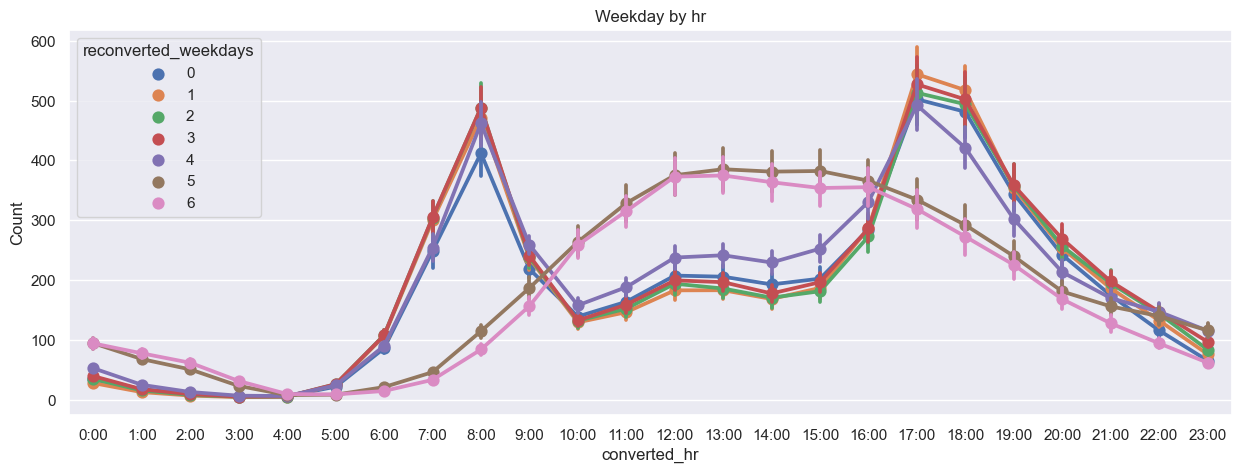

In [27]:
# EDA PLOTTING: Usage on reconverted_weekdays per hr

fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(data=data_hour, x='converted_hr', y='Count', hue='reconverted_weekdays', ax=ax)
ax.set(title='Weekday by hr')

C:\Users\rsend\AppData\Local\Temp\ipykernel_20192\3421850823.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_11 = tw_copy_2011.corr()


<Axes: >

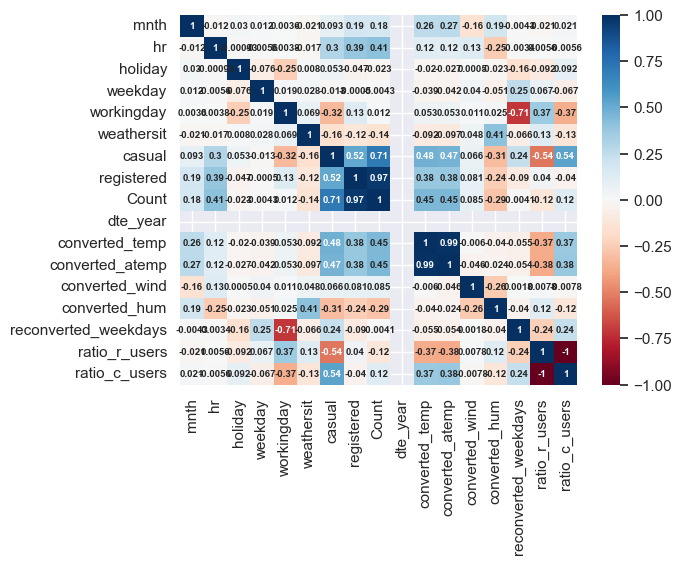

In [28]:
# EDA: 9.) Perform multivariant analysis (density, scatterplots, correlation matrix, heatmap): CREATE HEATMAP
tw_copy = data_hour.copy()

# excluded 'instant' from this code because apparently it has been deleted elsewhere
columns_to_drop = ['dteday','temp','atemp','hum','windspeed','Mon_to_Sun','is_holiday','is_weekend','clustered_hr_1','clustered_hr_2','season_2','data_anomaly','season','yr','yr_2011','yr_2012','dte_month','dteMonthC']
tw_copy.drop(columns_to_drop, axis=1, inplace=True)

tw_copy_2011 = tw_copy[tw_copy['dte_year'] == 2011]
# tw_copy_2012 =data_hour['dte_year'] == 2012

corr_11 = tw_copy_2011.corr()
sns.heatmap(corr_11, cmap='RdBu',vmin=-1,vmax=1, annot=True,annot_kws={'fontsize':7,'fontweight': 'bold'})

In [29]:
# RETURN TO EDA: ADD A RECONVERTED SEASON 2 (one that makes sense) where winter =4
rc_season_mapping = {'Spring' : 1,                  #rc_ ... = reconverted
                              'Summer' : 2,
                              'Autumn' : 3,
                              'Winter' : 4
                              }

data_hour['rc_season'] = data_hour['season_2'].map(rc_season_mapping)

<Axes: >

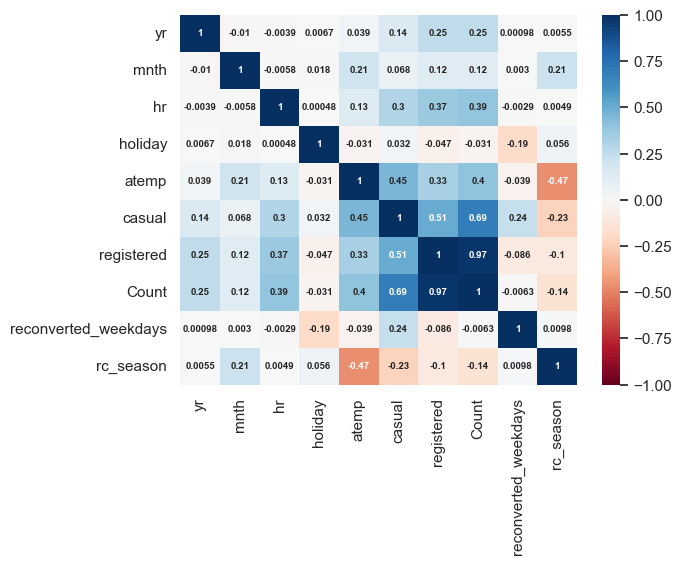

In [30]:
# 12: Since DF data_hour contains also non-int and non-float features, I'll need to exclude or convert them.

# EDA: 9.) Perform multivariant analysis (density, scatterplots, correlation matrix, heatmap): CREATE HEATMAP
d_hour = data_hour.copy()
d_hour_base = d_hour.copy()
d_hour_drop = ['dteday','season','weekday','workingday','weathersit','temp','hum','windspeed','converted_temp','converted_atemp','converted_wind','converted_hum','dteMonthC','Mon_to_Sun','dte_year','clustered_hr_1','clustered_hr_2','yr_2011','yr_2012','data_anomaly','converted_hr','is_holiday','is_weekend','formatted_string','season_2','dte_month','ratio_r_users', 'ratio_c_users']
d_hour_base.drop(d_hour_drop,axis=1,inplace=True)
d_hour_base.tail(5)

corr_d_hour_casual_time = d_hour_base.corr()
sns.heatmap(corr_d_hour_casual_time,cmap='RdBu',vmin=-1,vmax=1,annot=True,annot_kws={'fontsize':7,'fontweight':'bold'})

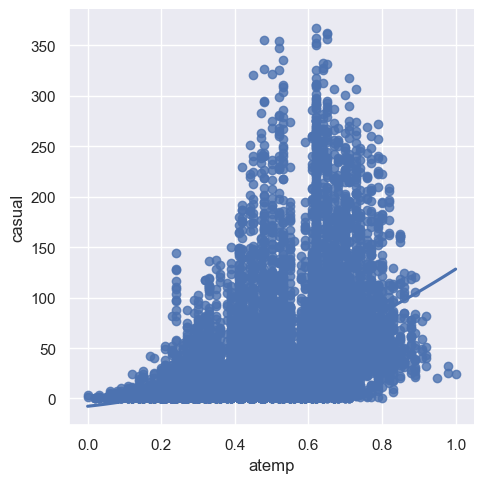

In [31]:
# EDA: Axis-Grid using perceived temperature and hourly csual users

sns.lmplot(x="atemp", y="casual", data=d_hour, order=2, ci=None)

# looks much better without categorical items, better used for big datasets with lots of float or int values (scales like salinity, temperature...)

In [32]:
#10 Calculation of analysis of variance (ANOVA)# 2 ways: F-Test Score and P-Value - not working without categories hence hashed out

# from scipy import stats
# F, p = stats.f_oneway(data_hour[data_hour['temp']]['Count'])
# print('ANOVA test for mean temp levels based on count')
# print('F Statistic:', F, '\tp-value:', p)

In [33]:
#10 Check for kurtosis
print(data_hour['Count'].astype(float).kurtosis())
print(data_hour['Count'].astype(float).skew())

1.4172032806553756
1.2774116037490577


Text(0.5, 1.0, 'Correlation heatmap')

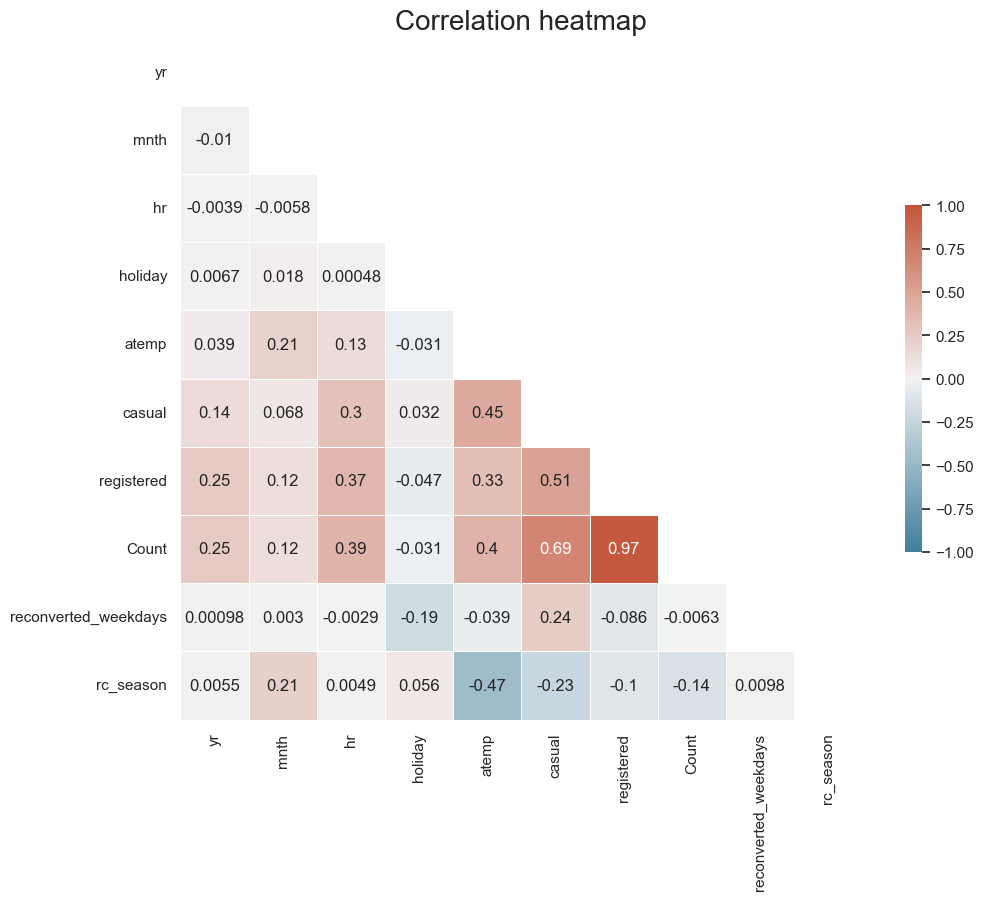

In [34]:
# New iterration: Strongly reduced heatmap
sns.set_theme(style="white")

# Compute the correlation matrix
corr = d_hour_base.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

plt.title('Correlation heatmap', fontsize=20)

In [35]:
# After analyzing the data I'll save it in order to use it in a separate file where the actual ML function will make use of it.

excel_file_path = r'C:\Users\rsend\Documents\2.) Coding\Projects(repository)\clipboard_folder\EDA_hour.xlsx'
d_hour_base.to_excel(excel_file_path, index=False)

excel_file_path_full = r'C:\Users\rsend\Documents\2.) Coding\Projects(repository)\clipboard_folder\EDA_hour_full.xlsx'
d_hour.to_excel(excel_file_path_full, index=False)
